In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
cd ..

/Users/yoshikawa/loutrebleu/workspace/qml


/opt/homebrew/Caskroom/miniconda/base/envs/lb-qml/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [10]:
import io
import cv2
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import namedtuple
from IPython.display import clear_output
from numpy.typing import NDArray
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

In [23]:
from qml.model.gate import get_gateset, Gate, GateInfo
from qml.model.unit import Unit, EmbedUnit, EntangleUnit
from qml.model.model import Model
from qml.tools.trainer import calc_gradients
from qml.tools.dataloader import DataLoader
from qml.tools.evaluator import Evaluator
from qml.optimizer.localsearch import LocalSearchOptimizer
from qml.tools.dataset import generate_dataset

In [12]:
%matplotlib inline

In [13]:
np.set_printoptions(precision=3, floatmode='fixed')

## Parameters

In [14]:
# circuit
num_qubits = nq = 2
num_gate_per_unit = ng = 3
num_unit_per_round = nu = 9

# dataset
dim_input = nx = 1
dim_output = ny = 1
num_train_data = 20
num_test_data = 20
gateset = get_gateset(nq)

# optimization
shots = 50
num_max_iter = 100
var_to_explore = 0.3

## Dataset

In [24]:
target_func = lambda x: np.sin(np.pi * x)

In [40]:
train_data = generate_dataset(num_train_data, target_func)
test_data = generate_dataset(num_test_data, target_func)

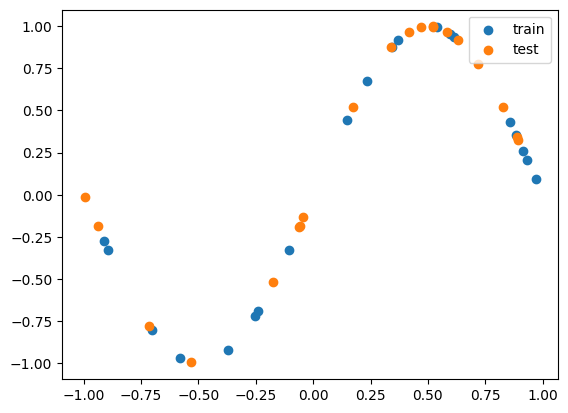

In [41]:
fig, ax = plt.subplots()
ax.scatter(*train_data.data, label="train")
ax.scatter(*test_data.data, label="test")
plt.legend()

## Prepare

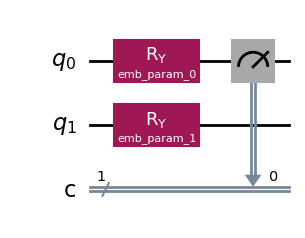

In [33]:
emb = EmbedUnit.generate_ry_arcsin_embed_unit("emb", nq, nx, gateset=gateset)
model = Model(nq, ny, emb, [], [], shots=shots)
model.draw()

## Calculate Error

In [42]:
predict = np.asarray([
    model.forward(x)
    for x in train_data.xs
])

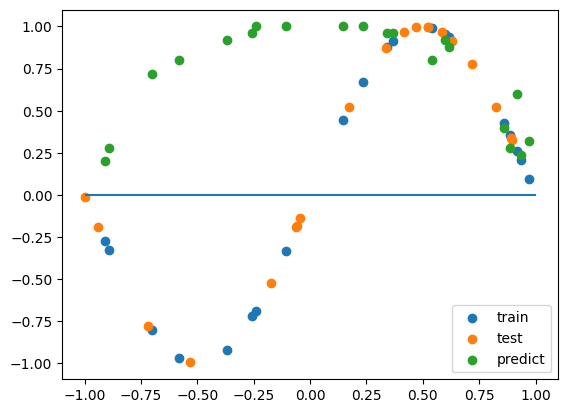

In [63]:
fig, ax = plt.subplots()
ax.scatter(*train_data.data, label="train")
ax.scatter(*test_data.data, label="test")
ax.scatter(train_data.xs, predict, label="predict")
plt.legend()
plt.show()

(-2.0, 2.0)

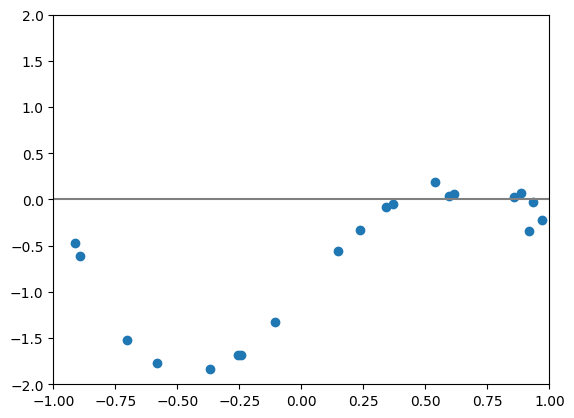

In [68]:
errors = train_data.ys - predict
plt.hlines(0, -1, 1, colors="gray")
plt.scatter(train_data.xs, errors)
plt.xlim(-1, 1)
plt.ylim(-2, 2)

In [56]:
demiN = int(train_data.size / 2)
error_fft = np.fft.fft(errors)
freq = np.fft.fftfreq(train_data.size, d=2/train_data.size)
amp = np.abs(error_fft / demiN)

In [58]:
freq

array([ 0.000,  0.500,  1.000,  1.500,  2.000,  2.500,  3.000,  3.500,
        4.000,  4.500, -5.000, -4.500, -4.000, -3.500, -3.000, -2.500,
       -2.000, -1.500, -1.000, -0.500])

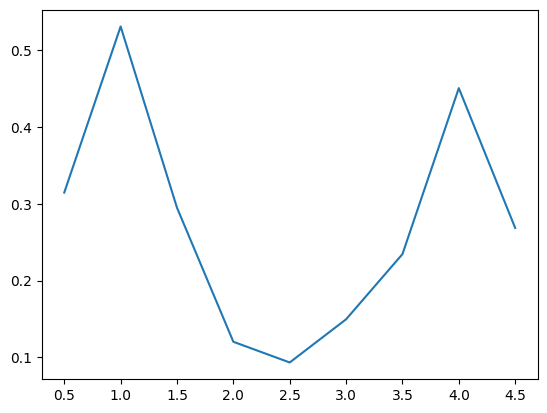

In [57]:
plt.plot(freq[1:demiN], amp[1:demiN])

In [62]:

freqs = [
    np.fft.fftfreq(train_data.size, d=2/(num+1)/10)[1:int((num+1)*5)]
    for num in range(10)
]
print(freqs)

[array([0.250, 0.500, 0.750, 1.000]), array([0.500, 1.000, 1.500, 2.000, 2.500, 3.000, 3.500, 4.000, 4.500]), array([ 0.750,  1.500,  2.250,  3.000,  3.750,  4.500,  5.250,  6.000,
        6.750, -7.500, -6.750, -6.000, -5.250, -4.500]), array([  1.000,   2.000,   3.000,   4.000,   5.000,   6.000,   7.000,
         8.000,   9.000, -10.000,  -9.000,  -8.000,  -7.000,  -6.000,
        -5.000,  -4.000,  -3.000,  -2.000,  -1.000]), array([  1.250,   2.500,   3.750,   5.000,   6.250,   7.500,   8.750,
        10.000,  11.250, -12.500, -11.250, -10.000,  -8.750,  -7.500,
        -6.250,  -5.000,  -3.750,  -2.500,  -1.250]), array([  1.500,   3.000,   4.500,   6.000,   7.500,   9.000,  10.500,
        12.000,  13.500, -15.000, -13.500, -12.000, -10.500,  -9.000,
        -7.500,  -6.000,  -4.500,  -3.000,  -1.500]), array([  1.750,   3.500,   5.250,   7.000,   8.750,  10.500,  12.250,
        14.000,  15.750, -17.500, -15.750, -14.000, -12.250, -10.500,
        -8.750,  -7.000,  -5.250,  -3.50